In [1]:

### parameters
place = 'tel_aviv'
feature = 'bench'

In [3]:

import geopandas as gpd
import osmnx as ox

import os
from pathlib import Path
import warnings
warnings.filterwarnings(action='ignore')
crs_prj = 'EPSG:2039'


# Get the current working directory (e.g., the folder you're running from)
cwd = Path().resolve()

# Get the parent directory
parent_folder = f'{cwd.parent}/places/{place}'
data_folder = f'{parent_folder}/shp'
os.makedirs(f'{parent_folder}',exist_ok=True)
os.makedirs(f'{parent_folder}/shp',exist_ok=True)
os.makedirs(f'{parent_folder}/shp/{feature}',exist_ok=True)
detail_folder = f'{data_folder}/{feature}'

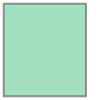

In [8]:

# --- 1. Load and project streets ---
streets = gpd.read_file(f"{data_folder}/streets.shp")[['oidrechov', 'geometry']]
streets = streets.to_crs(crs_prj)

# --- 2. Get bounding box in WGS84 for OSM query ---
bbox_wgs84 = streets.to_crs(epsg=4326).total_bounds  # (minx, miny, maxx, maxy)

# --- 3. Download benches from OpenStreetMap ---
tags = {"amenity": "bench"}
benches_raw = ox.features.features_from_bbox(bbox=tuple(bbox_wgs84), tags=tags)

# --- 4. Clean and save benches ---
benches = benches_raw[benches_raw.geometry.type == 'Point'].copy()
benches = benches.set_geometry('geometry').to_crs(crs_prj)[['geometry', 'amenity']]
benches.to_file(f"{detail_folder}/benches_pnts.shp")

# --- 5. Spatial join: find nearest street for each bench ---
benches_nearest = gpd.sjoin_nearest(
    benches[['geometry']],
    streets[['oidrechov', 'geometry']],
    how='left',
    distance_col='dist_to_road',
    max_distance=30  # meters
)

# --- 6. Count benches per street ---
bench_counts = benches_nearest.groupby('oidrechov').size().reset_index(name='bench_count')

# --- 7. Calculate street lengths and normalize ---
streets['length_m'] = streets.geometry.length
result = streets.merge(bench_counts, on='oidrechov', how='left')
result['bench_count'] = result['bench_count'].fillna(0)
result['benches_per_meter'] = result['bench_count'] / result['length_m']

# --- 8. Export result ---
result.to_file(f"{detail_folder}/{feature}.shp")